# Dealiasing Velocity

In [1]:
# The radial velocity measured by the radar is measured by detecting the phase shift between the
# transmitted pulse and the pulse received by the radar. However, using this methodology, it is
# only possible to detect phase shifts within +- 2pi due to the periodicity of the transmitted wave.
# Therefore, for example, a phase shift of 3pi would erroneously be detected as a phase shift of -pi
# and give an incorrect value of velocity when retrieved by the radar. This phenomena is called aliasing.
# The maximium unambious velocity that can be detected by the radar before aliasing occurs is called
# the Nyquist velocity.

In [2]:
# First import needed modules.
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
# Read the radar data.

In [4]:
radar = pyart.io.read("095636.mdv")

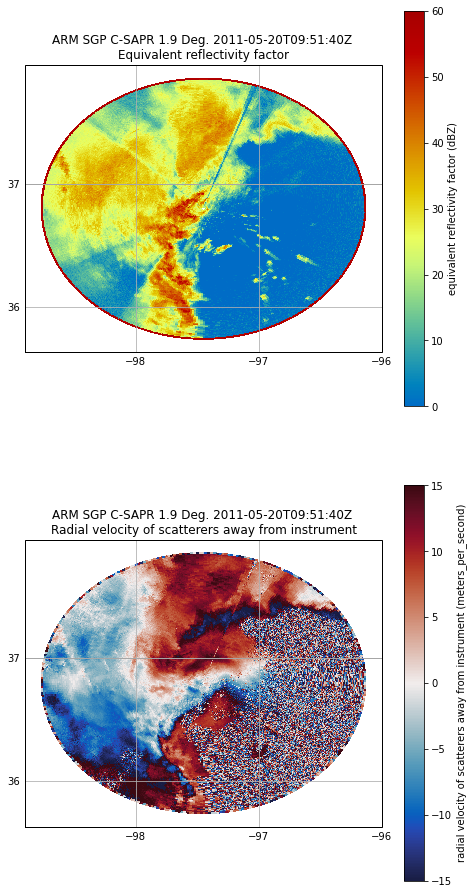

In [5]:
fig = plt.figure(figsize=[8,16])
ax = plt.subplot(2,1,1,projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity', sweep=2, resolution='50m',
                     vmin=0, vmax=60, 
                     projection=ccrs.PlateCarree())

ax2 = plt.subplot(2,1,2,projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('velocity', sweep=2, resolution='50m',
                     vmin=-15, vmax=15, 
                     projection=ccrs.PlateCarree(), cmap='pyart_balance')
plt.show()

In [6]:
# First, for dealiasing to work efficiently, we need to use a GateFilter. Looks like, and we need to
# do some preprocessing on the data to remove noise and clutter. Thankfully, Py-ART gives us the
# capability to do this. As a simple filter in this example, we will first calculate the velocity texture
# using Py-ART's calculate_velocity_texture function. The velocity texture is the standard deviation of
# velocity surrounding a gate. This will be higher in the presence of noise.

In [7]:
radar.instrument_parameters['nyquist_velocity']['data']

array([16.524973, 16.524973, 16.524973, ..., 16.524973, 16.524973,
       16.524973], dtype=float32)

In [8]:
# Set the nyquist to what we see in the instrument parameter above.
# Calculate the velocity texture
vel_texture = pyart.retrieve.calculate_velocity_texture(radar, vel_field='velocity', wind_size=3, nyq=16.524973)
radar.add_field('velocity_texture', vel_texture, replace_existing=True)

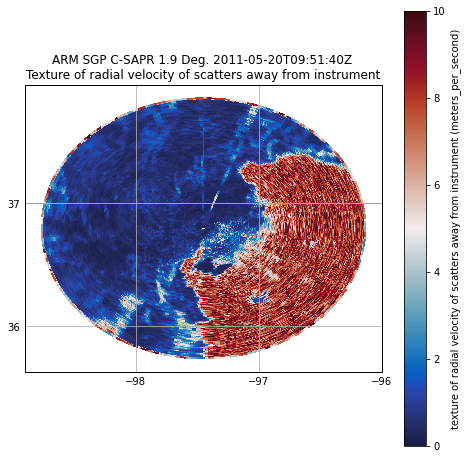

In [9]:
# Let us see what the velocity texture looks like.
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('velocity_texture', sweep=2, resolution='50m',
                     vmin=0, vmax=10, 
                     projection=ccrs.PlateCarree(), cmap='pyart_balance')
plt.show()

Text(0, 0.5, 'Count')

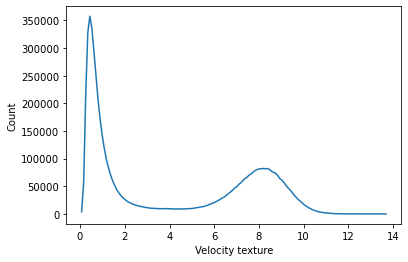

In [10]:
# Plot a histogram of velocity texture to get a better idea of what values correspond to
# hydrometeors and what values of texture correspond to artifacts.
# In the below example, a threshold of 3 would eliminate most of the peak corresponding to noise
# around 6 while preserving most of the values in the peak of ~0.5 corresponding to hydrometeors.
hist, bins = np.histogram(radar.fields['velocity_texture']['data'], bins=150)
bins = (bins[1:]+bins[:-1])/2.0
plt.plot(bins, hist)
plt.xlabel('Velocity texture')
plt.ylabel('Count')

In [11]:
# Set up the gatefilter to be based on the velocity texture.
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('velocity_texture', 3)

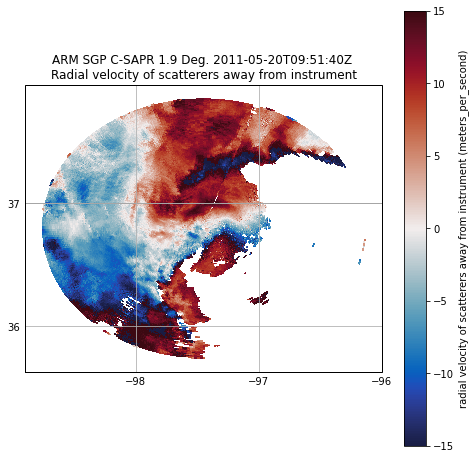

In [12]:
# Let us view the vleocity with the filter applied.
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('velocity', sweep=2, resolution='50m',
                     vmin=-15, vmax=15, 
                     projection=ccrs.PlateCarree(), cmap='pyart_balance',
                     gatefilter=gatefilter)
plt.show()

In [13]:
# At this point, we can simply used dealias_region_based to dealias the velocities
# and then add the new field to the radar.
nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
velocity_dealiased = pyart.correct.dealias_region_based(radar, vel_field='velocity', nyquist_vel=nyq,
                                                        centered=True, gatefilter=gatefilter)
radar.add_field('corrected_velocity', velocity_dealiased, replace_existing=True)

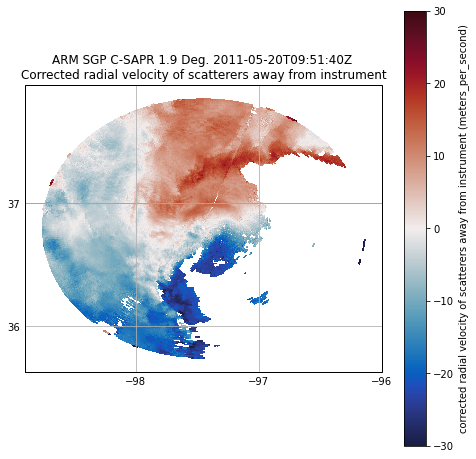

In [14]:
# Plot the new velocities, which now look much more realistic.
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('corrected_velocity', sweep=2, resolution='50m',
                     vmin=-30, vmax=30, 
                     projection=ccrs.PlateCarree(), cmap='pyart_balance',
                     gatefilter=gatefilter)
plt.show()